In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Encoder - MVP

> Self supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

In [40]:
from tchub.all import *
from fastcore.all import *
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!
from fastai.callback.wandb import WandbCallback
import wandb
wandb_api = wandb.Api()

In [41]:
config = AttrDict(
    alias = 'multiw', # Alias of the artifact resulting of this run. None will create one automatically
    wandb_group = None, # Whether to group this run in a wandb group
    wandb_entity = 'pacmel',
    wandb_project = 'tchub',
    train_artifact = 'pacmel/tchub/taxi:v0', # entity/project/name:version
    valid_artifact = 'pacmel/tchub/taxi:v0', # entity/project/name:version
    w = 48, # window size for the sliding window (taxi=48, steamflow=640)
    mvp_ws = (20, 48), # Tuple (min_w, max_x) to train MVP with adaptable window sizes. Usually max_w = config.w
    r = 0.5, # probability of masking in MVP
    stride = 1, # n datapoints the window is moved ahead along the sequence in the sliding window
    batch_size = 256,
    epochs = 50,
    use_wandb = True # Whether to use or not wandb for experiment trackin
)

In [42]:
#hide
run = wandb.init(entity = config.wandb_entity,
                      # work-nbs is a place to log draft runs
                      project=config.wandb_project if config.use_wandb else 'work-nbs',
                      group=config.wandb_group,
                      job_type='encoder_MVP',
                      allow_val_change=True,
                      mode='online' if config.use_wandb else 'disabled', # Need to be always online to download artifacts
                      config=config,
                      # When use_wandb is false the run is not linked to a personal account
                      #NOTE: This is not working right now
                      anonymous = 'never' if config.use_wandb else 'must',
                      resume=False)
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

In [43]:
train_artifact = artifacts_gettr(config.train_artifact)
valid_artifact = artifacts_gettr(config.valid_artifact)
df_train = train_artifact.to_df()
df_val = valid_artifact.to_df()
df_train.shape, df_val.shape

((3600, 1), (3600, 1))

In [44]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])
X_train, _ = sw(df_train)
X_valid, _ = sw(df_val)

print(f'Training shape: {X_train.shape}')
print(f'Validation shape: {X_valid.shape}')

Training shape: (3553, 1, 48)
Validation shape: (3553, 1, 48)


In [45]:
# y is not needed, but something is breaking in the dataloaders if we do not incldue it
X, _, splits  = combine_split_data(xs=[X_train, X_valid])
splits

((#3553) [0,1,2,3,4,5,6,7,8,9...],
 (#3553) [3553,3554,3555,3556,3557,3558,3559,3560,3561,3562...])

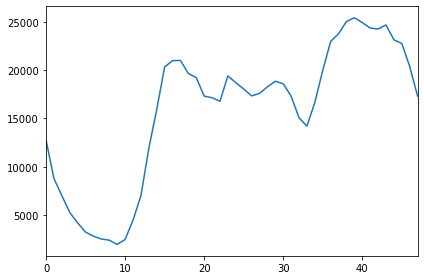

In [46]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dls.show_at(0)

Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

In [47]:
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

In [48]:
learn = ts_learner(dls, InceptionTimePlus, 
                   cbs= cbs + MVP(r = config.r, window_size=config.mvp_ws, 
                        target_dir='./models', fname=f'encoder_MVP'))
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))
learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley)
learn.plot_metrics()

KeyboardInterrupt: 

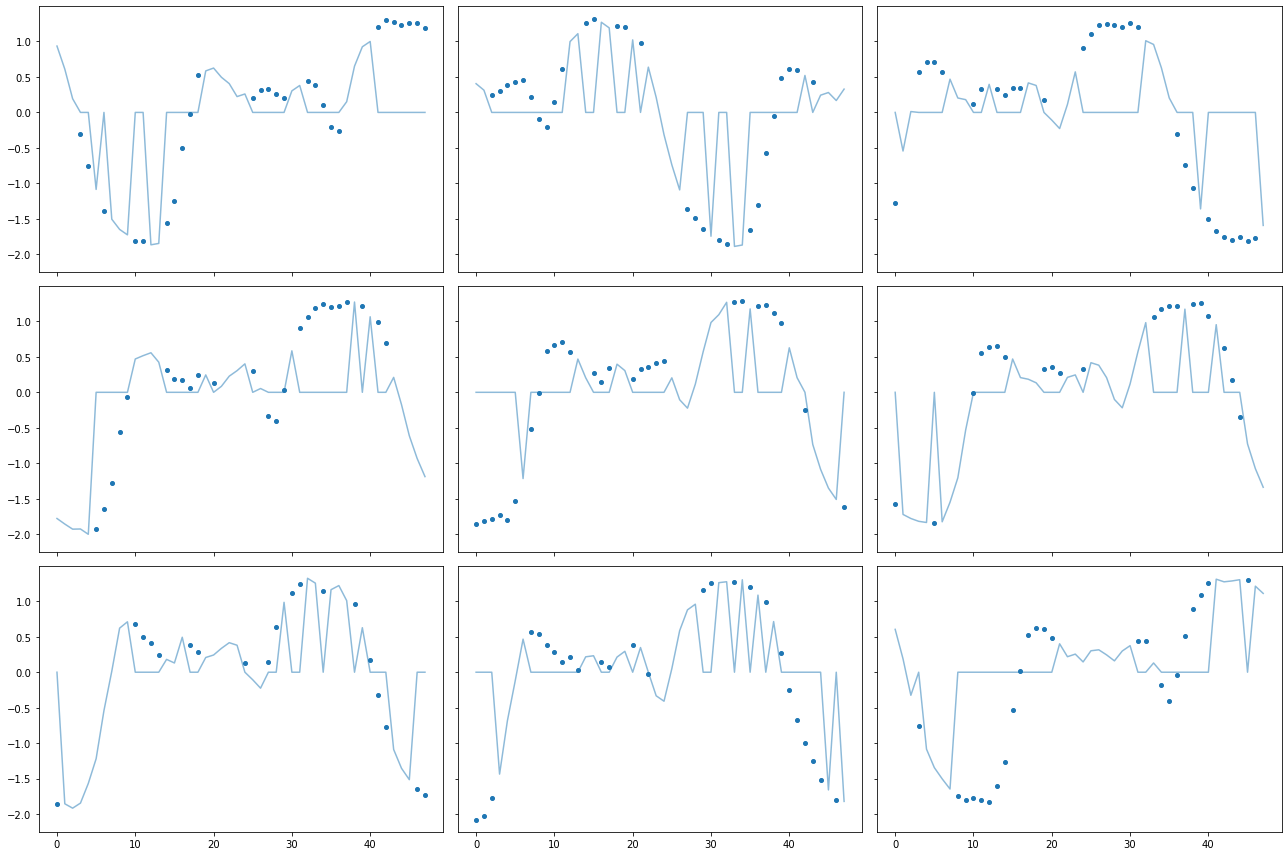

In [ ]:
learn.MVP.show_preds(sharey=True)

In [ ]:
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: run.log_artifact(ReferenceArtifact(aux_learn, f'mvp', type='learner', metadata=dict(run.config)), 
                                      aliases=config.alias)

In [ ]:
run.finish()